# Проект создания модели по определению возраста по фото для сети супермаркетов «Хлеб-Соль»

## Цели исследования

- Разработать модель на нейросетевой основе для индетификации возраста покупателей по фото , для формирования персональных рекомендаций и контроля по продаже алкогольной и табачной продукции.

## Ход исследования

- Загрузка и ознакомление с *таблиычными данными*


- Загрузка и ознакомление с *графической составляющей датасета*.


- Проверка соответствия фото табличной разметке.


- Перебор и обучение моделей для достижечения поставленной заказчиком задачи.


- Финальный вывод и рекомендации на основании полученных результатов.


# Исследовательский анализ данных

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import math
import os
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from typing import Dict, Any, Optional, Tuple
from scipy import stats
from PIL import Image

## Кастомные функции

In [2]:
def analyze_dataset_sizes(dataset_path):
    """Анализ размеров изображений в датасете"""
    sizes = []
    
    image_paths = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    
    print(f"Найдено изображений: {len(image_paths)}")
    
    for img_path in tqdm(image_paths, desc="Анализ изображений", unit="img"):
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)
        except Exception as e:
            pass
    
    if sizes:
        sizes = np.array(sizes)
        print(f"Успешно обработано изображений: {len(sizes)}")
        print(f"Минимальный размер: {sizes.min(axis=0)}")
        print(f"Максимальный размер: {sizes.max(axis=0)}")
        print(f"Средний размер: {sizes.mean(axis=0).astype(int)}")
        print(f"Медианный размер: {np.median(sizes, axis=0).astype(int)}")
    else:
        print("Не удалось обработать ни одного изображения")
    
    return sizes



In [3]:
def print_size_distribution(sizes, limit=100):
    """
    Вывод распределения изображений по размерам
    
    Parameters:
    -----------
    sizes : list of tuple or numpy array
        Список/массив кортежей (ширина, высота)
    limit : int, optional
        Количество отображаемых размеров (по умолчанию 100)
    """
    import numpy as np
    
    # Проверка и преобразование входных данных
    if hasattr(sizes, 'size'):
        # Для numpy массивов
        if sizes.size == 0:
            print("Нет данных для анализа")
            return
        total_images = len(sizes)
        # Преобразуем к списку для удобства
        sizes_list = [(w, h) for w, h in sizes]
    else:
        # Для обычных списков
        if not sizes or len(sizes) == 0:
            print("Нет данных для анализа")
            return
        total_images = len(sizes)
        sizes_list = sizes
    
    print("\n" + "="*60)
    print("РАСПРЕДЕЛЕНИЕ ПО РАЗМЕРАМ")
    print("="*60)
    
    # Подготовка данных
    size_counts = {}
    for width, height in sizes_list:
        size_key = f"{int(width)}×{int(height)}"
        size_counts[size_key] = size_counts.get(size_key, 0) + 1
    
    # Сортировка по количеству (по убыванию)
    sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Определение фактического количества для вывода
    display_limit = min(limit, len(sorted_sizes))
    
    # Вывод топ-N размеров
    print(f"\nТоп-{display_limit} самых частых размеров (всего уникальных: {len(sorted_sizes)}):")
    print("-" * 50)
    print(f"{'Размер':<15} {'Количество':<12} {'Процент':<10} {'Кумулятивно':<12}")
    print("-" * 50)
    
    cumulative_percentage = 0
    for i, (size, count) in enumerate(sorted_sizes[:display_limit]):
        percentage = (count / total_images) * 100
        cumulative_percentage += percentage
        
        # Отметка для часто встречающихся размеров
        marker = "🔥" if percentage > 10 else "⭐" if percentage > 5 else ""
        
        print(f"{size:<15} {count:<12} {percentage:>6.1f}% {cumulative_percentage:>10.1f}%  {marker}")
    
    # Статистика по группам
    print(f"\n📊 ГРУППИРОВКА ПО КАТЕГОРИЯМ:")
    print("-" * 40)
    
    # Более гибкие критерии для квадратных изображений
    square = sum(1 for w, h in sizes_list if 0.95 <= w/h <= 1.05)  # строгий квадрат
    square_approx = sum(1 for w, h in sizes_list if 0.9 <= w/h <= 1.1)  # приблизительный квадрат
    landscape = sum(1 for w, h in sizes_list if w/h > 1.1)  # альбомные
    portrait = sum(1 for w, h in sizes_list if w/h < 0.9)  # портретные
    
    print(f"   Квадратные (1:1 ±5%): {square:>5} ({square/total_images*100:>5.1f}%)")
    print(f"   Квадратные (1:1 ±10%): {square_approx:>4} ({square_approx/total_images*100:>5.1f}%)")
    print(f"   Альбомные (широкие): {landscape:>6} ({landscape/total_images*100:>5.1f}%)")
    print(f"   Портретные (высокие): {portrait:>5} ({portrait/total_images*100:>5.1f}%)")
    
    # Дополнительная статистика
    print(f"\n📈 СТАТИСТИКА:")
    print("-" * 40)
    
    if total_images > 0:
        # Безопасное вычисление средних значений
        widths = [w for w, h in sizes_list]
        heights = [h for w, h in sizes_list]
        ratios = [w/h for w, h in sizes_list if h != 0]  # избегаем деления на 0
        
        avg_width = sum(widths) / total_images
        avg_height = sum(heights) / total_images
        avg_ratio = sum(ratios) / len(ratios) if ratios else 0
        
        print(f"   Средняя ширина: {avg_width:.0f}px")
        print(f"   Средняя высота: {avg_height:.0f}px")
        print(f"   Среднее соотношение: {avg_ratio:.2f}:1")
        
        # Минимальные и максимальные значения
        min_width, min_height = min(widths), min(heights)
        max_width, max_height = max(widths), max(heights)
        
        print(f"   Мин. размер: {min_width}×{min_height}px")
        print(f"   Макс. размер: {max_width}×{max_height}px")
        
        # Самые частые разрешения
        print(f"\n🎯 САМЫЕ ЧАСТЫЕ РАЗРЕШЕНИЯ:")
        print("-" * 40)
        top_count = min(5, display_limit)
        for size, count in sorted_sizes[:top_count]:
            percentage = (count / total_images) * 100
            print(f"   {size}: {count} изображений ({percentage:.1f}%)")
    
    print("\n" + "="*60)




In [4]:
def analyze_numeric_variable(
    data: pd.Series,
    variable_name: str = None,
    plot: bool = True,
    figsize: Tuple[int, int] = (15, 10)
) -> Dict[str, Any]:
    """
    Полный анализ числовой переменной.
    
    Параметры:
    ----------
    data : pd.Series
        Числовая переменная для анализа
    variable_name : str, optional
        Имя переменной (для заголовков графиков)
    plot : bool, default True
        Создавать ли графики
    figsize : tuple, default (15, 10)
        Размер фигуры для графиков
    
    Возвращает:
    -----------
    dict : Словарь с результатами анализа
    """
    
    if variable_name is None:
        variable_name = data.name if data.name else "Variable"
    
    # Проверяем, является ли переменная числовой
    if not pd.api.types.is_numeric_dtype(data):
        # Пробуем преобразовать к числовому типу
        try:
            data = pd.to_numeric(data, errors='coerce')
            print(f"Переменная '{variable_name}' была преобразована к числовому типу")
        except:
            raise TypeError(f"Переменная '{variable_name}' не является числовой и не может быть преобразована")
    
    # Удаление пропущенных значений для анализа
    clean_data = data.dropna()
    
    if len(clean_data) == 0:
        print(f"Предупреждение: переменная '{variable_name}' содержит только пропущенные значения")
        return {
            'variable_name': variable_name,
            'count': 0,
            'missing_values': data.isnull().sum(),
            'missing_percentage': 100.0,
            'error': 'No valid numeric data'
        }
    
    # Базовые статистики
    results = {
        'variable_name': variable_name,
        'count': len(clean_data),
        'missing_values': data.isnull().sum(),
        'missing_percentage': (data.isnull().sum() / len(data)) * 100,
        'mean': float(clean_data.mean()),
        'median': float(clean_data.median()),
        'std': float(clean_data.std()),
        'variance': float(clean_data.var()),
        'min': float(clean_data.min()),
        'max': float(clean_data.max()),
        'range': float(clean_data.max() - clean_data.min()),
        'q1': float(clean_data.quantile(0.25)),
        'q3': float(clean_data.quantile(0.75)),
        'iqr': float(clean_data.quantile(0.75) - clean_data.quantile(0.25)),
        'skewness': float(clean_data.skew()),
        'kurtosis': float(clean_data.kurtosis()),
        'coefficient_of_variation': (clean_data.std() / clean_data.mean()) * 100 if clean_data.mean() != 0 else np.nan,
        'mode': float(clean_data.mode().iloc[0]) if not clean_data.mode().empty else np.nan,
        'mode_frequency': int((clean_data == clean_data.mode().iloc[0]).sum()) if not clean_data.mode().empty else np.nan,
    }
    
    # Процентили
    percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    for p in percentiles:
        results[f'percentile_{int(p*100)}'] = float(clean_data.quantile(p))
    
    # Проверка на нормальность
    if len(clean_data) > 3:
        try:
            # Для выборок до 5000 используем Shapiro-Wilk, для больших - KS
            if len(clean_data) <= 5000:
                shapiro_stat, shapiro_p = stats.shapiro(clean_data)
                results['shapiro_test_statistic'] = float(shapiro_stat)
                results['shapiro_test_pvalue'] = float(shapiro_p)
                results['is_normal_shapiro'] = shapiro_p > 0.05
            else:
                results['shapiro_test_statistic'] = np.nan
                results['shapiro_test_pvalue'] = np.nan
                results['is_normal_shapiro'] = None
            
            # Тест Колмогорова-Смирнова
            ks_stat, ks_p = stats.kstest(clean_data, 'norm', 
                                        args=(clean_data.mean(), clean_data.std()))
            results['ks_test_statistic'] = float(ks_stat)
            results['ks_test_pvalue'] = float(ks_p)
            results['is_normal_ks'] = ks_p > 0.05
        except Exception as e:
            print(f"Ошибка при проверке нормальности: {e}")
    
    # Выбросы (по правилу 1.5*IQR)
    Q1 = results['q1']
    Q3 = results['q3']
    IQR = results['iqr']
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = clean_data[(clean_data < lower_bound) | (clean_data > upper_bound)]
    results['outliers_count'] = int(len(outliers))
    results['outliers_percentage'] = (len(outliers) / len(clean_data)) * 100
    results['outliers_lower_bound'] = float(lower_bound)
    results['outliers_upper_bound'] = float(upper_bound)
    
    # Создание графиков
    if plot and len(clean_data) > 0:
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle(f'Анализ переменной: {variable_name}', fontsize=16, y=1.02)
        
        # 1. Гистограмма с KDE (с обработкой ошибок)
        try:
            axes[0, 0].hist(clean_data, bins='auto', edgecolor='black', alpha=0.7, density=True)
            # Используем bw_adjust вместо устаревших параметров
            sns.kdeplot(data=clean_data, ax=axes[0, 0], color='red', linewidth=2, bw_adjust=0.5)
        except Exception as e:
            # Если KDE не работает, строим только гистограмму
            axes[0, 0].hist(clean_data, bins='auto', edgecolor='black', alpha=0.7)
            axes[0, 0].set_title('Гистограмма (KDE недоступен)')
        
        axes[0, 0].axvline(results['mean'], color='green', linestyle='--', 
                          label=f'Среднее: {results["mean"]:.2f}')
        axes[0, 0].axvline(results['median'], color='orange', linestyle='--', 
                          label=f'Медиана: {results["median"]:.2f}')
        axes[0, 0].set_title('Гистограмма с KDE')
        axes[0, 0].set_xlabel('Значения')
        axes[0, 0].set_ylabel('Плотность')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Box plot
        axes[0, 1].boxplot(clean_data, vert=True, patch_artist=True)
        axes[0, 1].set_title('Box Plot')
        axes[0, 1].set_ylabel('Значения')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. QQ plot (с обработкой ошибок)
        try:
            stats.probplot(clean_data, dist="norm", plot=axes[0, 2])
            axes[0, 2].set_title('QQ Plot (нормальное распределение)')
        except Exception as e:
            axes[0, 2].text(0.5, 0.5, 'QQ Plot\nнедоступен', 
                           ha='center', va='center', transform=axes[0, 2].transAxes)
            axes[0, 2].set_title('QQ Plot (ошибка)')
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Violin plot (с обработкой ошибок)
        try:
            sns.violinplot(y=clean_data, ax=axes[1, 0])
            axes[1, 0].set_title('Violin Plot')
        except Exception as e:
            axes[1, 0].text(0.5, 0.5, 'Violin Plot\nнедоступен', 
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Violin Plot (ошибка)')
        axes[1, 0].set_ylabel('Значения')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Эмпирическая функция распределения
        try:
            sorted_data = np.sort(clean_data)
            ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            axes[1, 1].plot(sorted_data, ecdf, linewidth=2)
            axes[1, 1].set_title('Эмпирическая функция распределения (ECDF)')
            axes[1, 1].set_xlabel('Значения')
            axes[1, 1].set_ylabel('Вероятность')
        except Exception as e:
            axes[1, 1].text(0.5, 0.5, 'ECDF\nнедоступен', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('ECDF (ошибка)')
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Текстовая информация
        axes[1, 2].axis('off')
        
        # Форматируем числовые значения
        mean_str = f"{results['mean']:.4f}"
        median_str = f"{results['median']:.4f}"
        std_str = f"{results['std']:.4f}"
        skew_str = f"{results['skewness']:.4f}"
        
        text_info = f"""
        Основные статистики:
        --------------------
        N: {results['count']:,}
        Пропуски: {results['missing_values']} ({results['missing_percentage']:.1f}%)
        Среднее: {mean_str}
        Медиана: {median_str}
        Std: {std_str}
        Min: {results['min']:.4f}
        Max: {results['max']:.4f}
        Асимметрия: {skew_str}
        Эксцесс: {results['kurtosis']:.4f}
        Выбросы: {results['outliers_count']} ({results['outliers_percentage']:.1f}%)
        """
        axes[1, 2].text(0.1, 0.5, text_info, transform=axes[1, 2].transAxes,
                       fontsize=9, verticalalignment='center',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
    
    return results


def print_numeric_summary(results: Dict[str, Any]):
    """
    Красиво выводит результаты анализа числовой переменной.
    
    Параметры:
    ----------
    results : dict
        Результаты из функции analyze_numeric_variable
    """
    if 'error' in results:
        print(f"Ошибка анализа: {results['error']}")
        return
    
    print("=" * 80)
    print(f"АНАЛИЗ ЧИСЛОВОЙ ПЕРЕМЕННОЙ: {results['variable_name']}")
    print("=" * 80)
    
    print("\n📊 ОСНОВНЫЕ СТАТИСТИКИ:")
    print("-" * 40)
    print(f"{'Объем данных:':<25} {results['count']:,}")
    print(f"{'Пропущенные значения:':<25} {results['missing_values']} ({results['missing_percentage']:.1f}%)")
    print(f"{'Среднее:':<25} {results['mean']:.4f}")
    print(f"{'Медиана:':<25} {results['median']:.4f}")
    print(f"{'Стандартное отклонение:':<25} {results['std']:.4f}")
    print(f"{'Дисперсия:':<25} {results['variance']:.4f}")
    print(f"{'Минимум:':<25} {results['min']:.4f}")
    print(f"{'Максимум:':<25} {results['max']:.4f}")
    print(f"{'Размах:':<25} {results['range']:.4f}")
    
    print("\n📈 КВАРТИЛИ И ПРОЦЕНТИЛИ:")
    print("-" * 40)
    print(f"{'Q1 (25%):':<25} {results['q1']:.4f}")
    print(f"{'Q2 (50%, медиана):':<25} {results['median']:.4f}")
    print(f"{'Q3 (75%):':<25} {results['q3']:.4f}")
    print(f"{'IQR:':<25} {results['iqr']:.4f}")
    print(f"{'P05:':<25} {results.get('percentile_5', 'N/A'):.4f}")
    print(f"{'P95:':<25} {results.get('percentile_95', 'N/A'):.4f}")
    
    print("\n🎭 ФОРМА РАСПРЕДЕЛЕНИЯ:")
    print("-" * 40)
    skewness = results['skewness']
    skew_interpretation = "симметричное" if abs(skewness) < 0.5 else \
                         "умеренно асимметричное" if abs(skewness) < 1 else \
                         "сильно асимметричное"
    print(f"{'Асимметрия:':<25} {skewness:.4f} ({skew_interpretation})")
    
    kurtosis = results['kurtosis']
    kurt_interpretation = "нормальное" if abs(kurtosis) < 0.5 else \
                         "островершинное" if kurtosis > 0.5 else \
                         "плосковершинное"
    print(f"{'Эксцесс:':<25} {kurtosis:.4f} ({kurt_interpretation})")
    
    cv = results['coefficient_of_variation']
    if not np.isnan(cv):
        print(f"{'Коэф. вариации:':<25} {cv:.1f}%")
    else:
        print(f"{'Коэф. вариации:':<25} N/A (среднее равно 0)")
    
    print("\n🔍 ВЫБРОСЫ (по правилу 1.5*IQR):")
    print("-" * 40)
    print(f"{'Нижняя граница:':<25} {results['outliers_lower_bound']:.4f}")
    print(f"{'Верхняя граница:':<25} {results['outliers_upper_bound']:.4f}")
    print(f"{'Количество выбросов:':<25} {results['outliers_count']}")
    print(f"{'Процент выбросов:':<25} {results['outliers_percentage']:.2f}%")
    
    if 'is_normal_shapiro' in results and results['is_normal_shapiro'] is not None:
        print("\n📊 ТЕСТЫ НА НОРМАЛЬНОСТЬ:")
        print("-" * 40)
        print(f"{'Тест Шапиро-Уилка:':<25} {'Нормальное' if results['is_normal_shapiro'] else 'Ненормальное'}")
        if results['is_normal_shapiro'] is not None:
            print(f"{'p-value:':<25} {results['shapiro_test_pvalue']:.4f}")
        print(f"{'Тест Колмогорова-Смирнова:':<25} {'Нормальное' if results['is_normal_ks'] else 'Ненормальное'}")
        print(f"{'p-value:':<25} {results['ks_test_pvalue']:.4f}")
    
    print("\n💡 ИНТЕРПРЕТАЦИЯ:")
    print("-" * 40)
    if results['missing_percentage'] > 5:
        print(f"⚠️  Высокий процент пропусков ({results['missing_percentage']:.1f}%)")
    
    if abs(skewness) > 1:
        direction = "правый" if skewness > 0 else "левый"
        print(f"⚠️  Сильная асимметрия распределения ({direction} хвост)")
    
    if results['outliers_percentage'] > 5:
        print(f"⚠️  Много выбросов ({results['outliers_percentage']:.1f}%)")
    
    if not np.isnan(cv):
        if cv > 30:
            print(f"⚠️  Высокая изменчивость данных (CV = {cv:.1f}%)")
        elif cv < 10:
            print(f"✓ Низкая изменчивость данных (CV = {cv:.1f}%)")

In [5]:
def visualize_size_stats(sizes):
    """Визуализация статистики по размерам"""
    if len(sizes) == 0:
        return
    
    sizes_array = np.array(sizes)
    widths = sizes_array[:, 0]
    heights = sizes_array[:, 1]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Статистика размеров изображений в датасете', fontsize=16)
    
    # 1. Гистограмма ширины
    axes[0, 0].hist(widths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Распределение ширины')
    axes[0, 0].set_xlabel('Ширина (px)')
    axes[0, 0].set_ylabel('Количество')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Гистограмма высоты
    axes[0, 1].hist(heights, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Распределение высоты')
    axes[0, 1].set_xlabel('Высота (px)')
    axes[0, 1].set_ylabel('Количество')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Scatter plot
    axes[0, 2].scatter(widths, heights, alpha=0.5, s=10, color='red')
    axes[0, 2].set_title('Соотношение ширина/высота')
    axes[0, 2].set_xlabel('Ширина (px)')
    axes[0, 2].set_ylabel('Высота (px)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Box plot ширины
    axes[1, 0].boxplot(widths, vert=False)
    axes[1, 0].set_title('Box plot ширины')
    axes[1, 0].set_xlabel('Ширина (px)')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Box plot высоты
    axes[1, 1].boxplot(heights, vert=False)
    axes[1, 1].set_title('Box plot высоты')
    axes[1, 1].set_xlabel('Высота (px)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Гистограмма соотношения сторон
    ratios = widths / heights
    axes[1, 2].hist(ratios, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 2].set_title('Распределение соотношения сторон')
    axes[1, 2].set_xlabel('Соотношение (ширина/высота)')
    axes[1, 2].set_ylabel('Количество')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Загрузка данных и первичное ознакомление.

### Анализ классов(возраста)

Для начала загрузим датасет с метками классов и посмотрим на структуру данных.

In [6]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


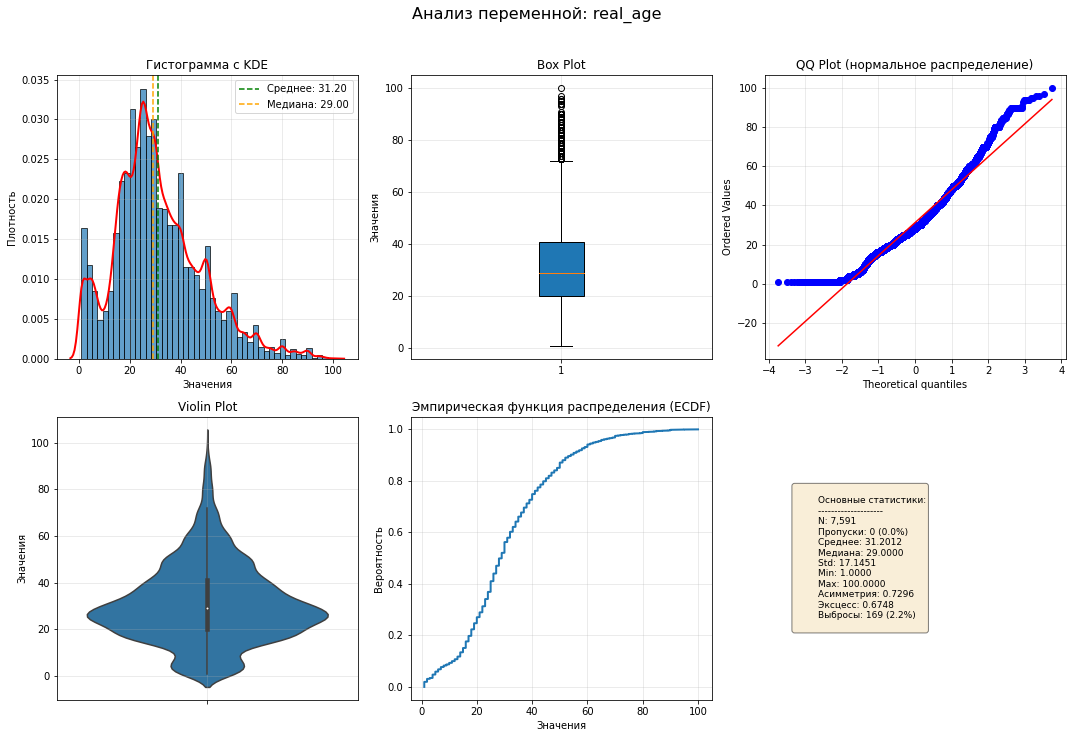

АНАЛИЗ ЧИСЛОВОЙ ПЕРЕМЕННОЙ: real_age

📊 ОСНОВНЫЕ СТАТИСТИКИ:
----------------------------------------
Объем данных:             7,591
Пропущенные значения:     0 (0.0%)
Среднее:                  31.2012
Медиана:                  29.0000
Стандартное отклонение:   17.1451
Дисперсия:                293.9531
Минимум:                  1.0000
Максимум:                 100.0000
Размах:                   99.0000

📈 КВАРТИЛИ И ПРОЦЕНТИЛИ:
----------------------------------------
Q1 (25%):                 20.0000
Q2 (50%, медиана):        29.0000
Q3 (75%):                 41.0000
IQR:                      21.0000
P05:                      5.0000
P95:                      63.0000

🎭 ФОРМА РАСПРЕДЕЛЕНИЯ:
----------------------------------------
Асимметрия:               0.7296 (умеренно асимметричное)
Эксцесс:                  0.6748 (островершинное)
Коэф. вариации:           55.0%

🔍 ВЫБРОСЫ (по правилу 1.5*IQR):
----------------------------------------
Нижняя граница:           -11.5000
Верхняя 

In [9]:
results = analyze_numeric_variable(df['real_age'], plot=True)
print_numeric_summary(results)

Видим что значения возраста в целом близки к нормальному распределенгию.

Есть как аномально низкие так и аномально высокие значения.

На этом этапе данные о возрасте представленных в датасете лиц , выглядит нормально.

**Детальный анализ возраста**

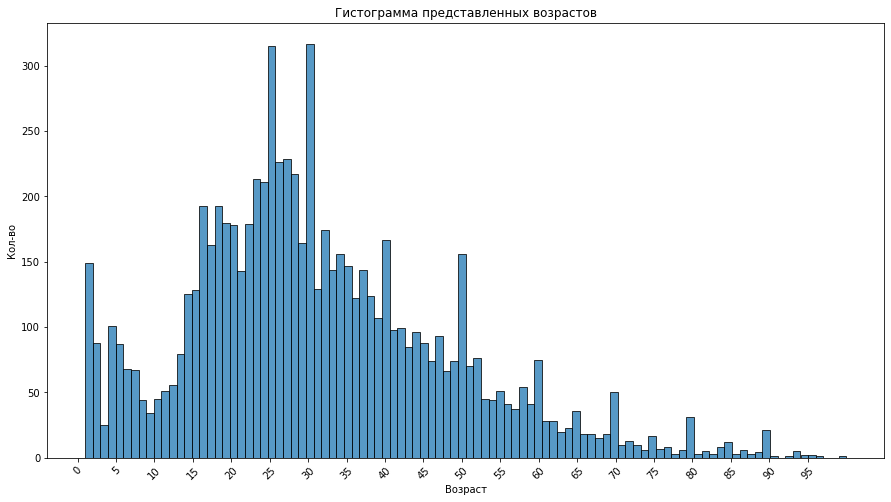

In [29]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
sns.histplot(data=df, x='real_age', bins=100)
plt.xticks(range(0, 100, 5), rotation=45)
ax.set_title('Гистограмма представленных возрастов')
ax.set_xlabel('Возраст')
ax.set_ylabel('Кол-во')
plt.show()

Видим явные пики на значениях кратных 10 , возможно это вызванно тем что при разметке не по всеми фото были точны данные и метка присваивалась примерно.

### Анализ графических данных.

Посмотрим на характеристики графической составляющей нашего датасета.

In [33]:
path = '/datasets/faces/final_files'

In [11]:
result = analyze_dataset_sizes(path)

Найдено изображений: 7591


Анализ изображений: 100%|██████████| 7591/7591 [01:40<00:00, 75.57img/s]

Успешно обработано изображений: 7591
Минимальный размер: [47 47]
Максимальный размер: [4466 4466]
Средний размер: [464 464]
Медианный размер: [385 384]


In [12]:
print_size_distribution(result, 50)


РАСПРЕДЕЛЕНИЕ ПО РАЗМЕРАМ

Топ-50 самых частых размеров (всего уникальных: 2293):
--------------------------------------------------
Размер          Количество   Процент    Кумулятивно 
--------------------------------------------------
165×165         37              0.5%        0.5%  
517×517         37              0.5%        1.0%  
166×166         31              0.4%        1.4%  
331×331         28              0.4%        1.8%  
257×257         27              0.4%        2.1%  
434×434         27              0.4%        2.5%  
184×184         24              0.3%        2.8%  
190×190         23              0.3%        3.1%  
355×355         22              0.3%        3.4%  
251×251         22              0.3%        3.7%  
231×231         22              0.3%        4.0%  
632×632         21              0.3%        4.2%  
204×204         21              0.3%        4.5%  
247×247         21              0.3%        4.8%  
577×577         21              0.3%        5.1%

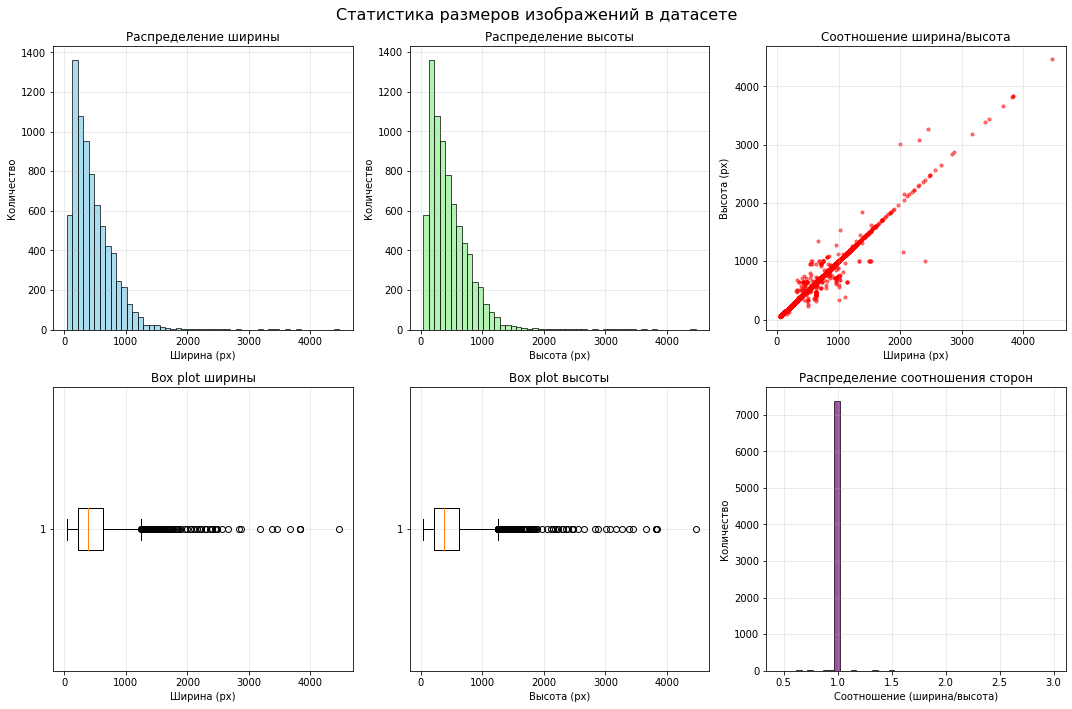

In [13]:
visualize_size_stats(result)

Видим что большая часть данных имеет формат 1:1 и размерность до 1000 пикселей по каждой из осей.

Так же удалось обнаружить что имееются некоторые аномально большие фотографии размерность может достигать 4466x4466p.

Эта информация пригодится нам при инициализации ImageDataGenerator и выбора финального размера фото.

Проверим на фото с *аномальными* возрастом до 5 лет и 90 лет что бы убедится в достоверности данных.

Выведем 15 случайных изображений , что бы убедится в соответсвии датасета поставленной задаче.

In [14]:
childs = df.loc[df['real_age'] < 5, 'file_name'].tolist()

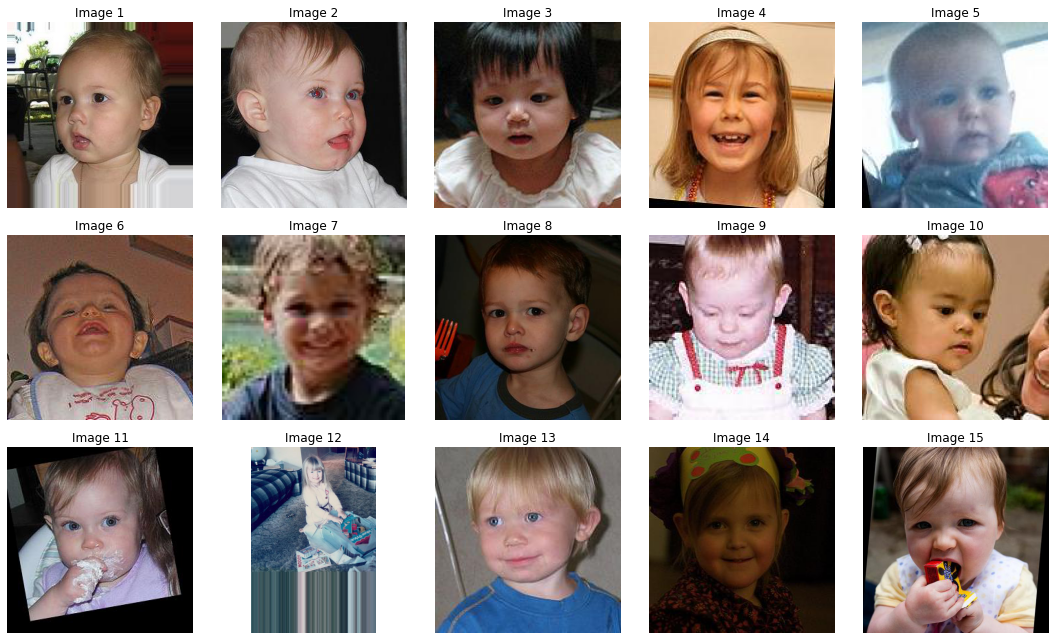

In [15]:
ages = random.sample(childs, 15) #можно указать кол-во семплов


fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for idx in range(len(ages)):
    img_path = os.path.join(path, ages[idx])
    img = mpimg.imread(img_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"Image {idx+1}")

plt.tight_layout()
plt.show()

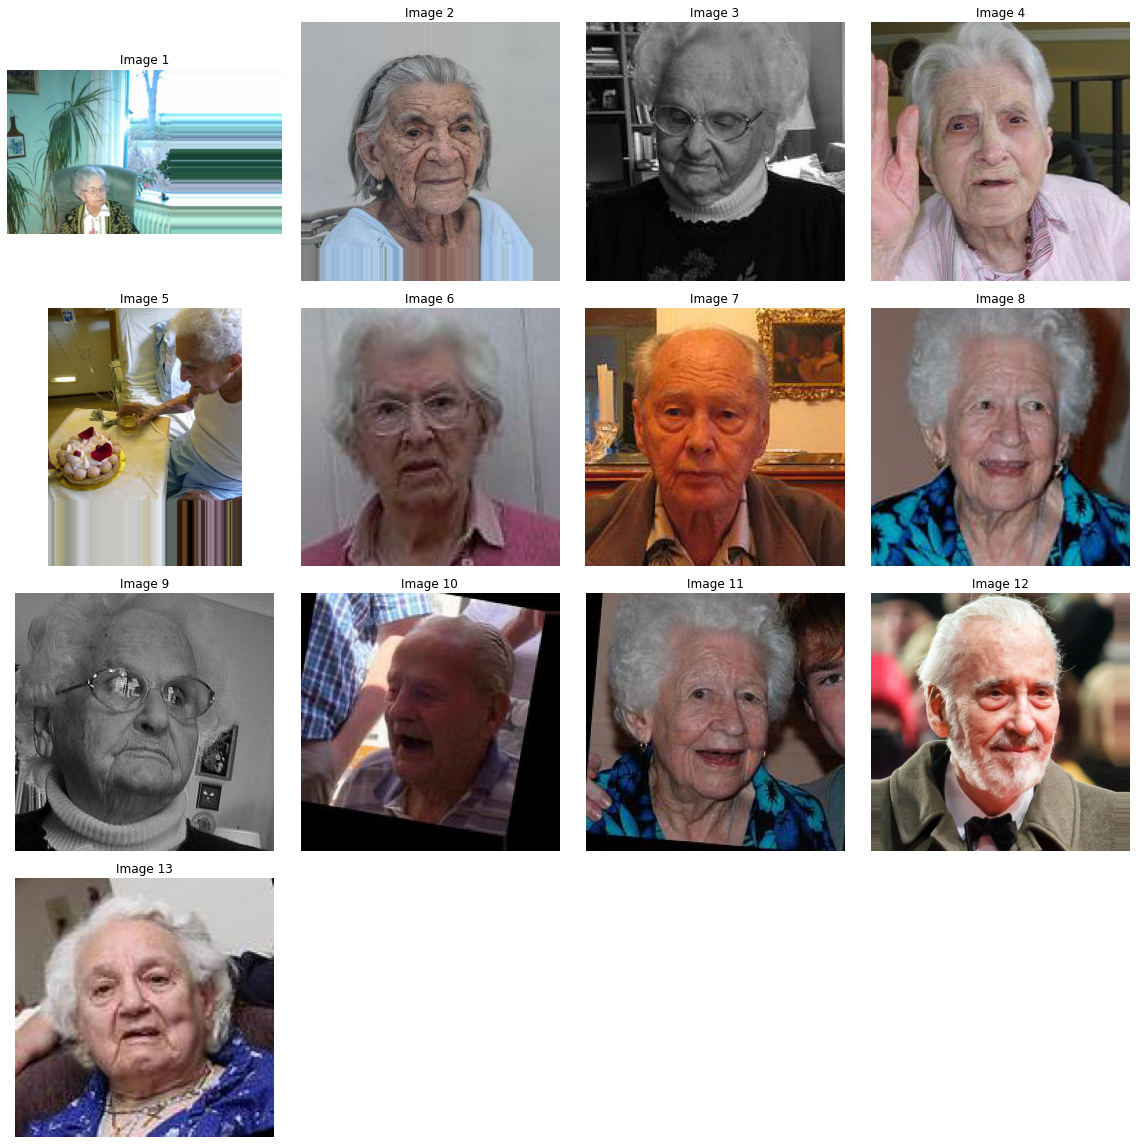

In [16]:
olds = df.loc[df['real_age'] > 90, 'file_name'].tolist() # Всего 13 фото выведем Все , без random.


cols = 4
rows = math.ceil(len(olds) / cols)
    
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    
axes_flat = axes.flatten()
    
    
for idx, old_file in enumerate(olds):
    img_path = os.path.join(path, old_file)
    img = mpimg.imread(img_path)
    axes_flat[idx].imshow(img)
    axes_flat[idx].axis('off')
    axes_flat[idx].set_title(f"Image {idx+1}")
    
for idx in range(len(olds), len(axes_flat)):
    axes_flat[idx].axis('off')
    
plt.tight_layout()
plt.show()

In [35]:
df.columns

Index(['file_name', 'real_age'], dtype='object')

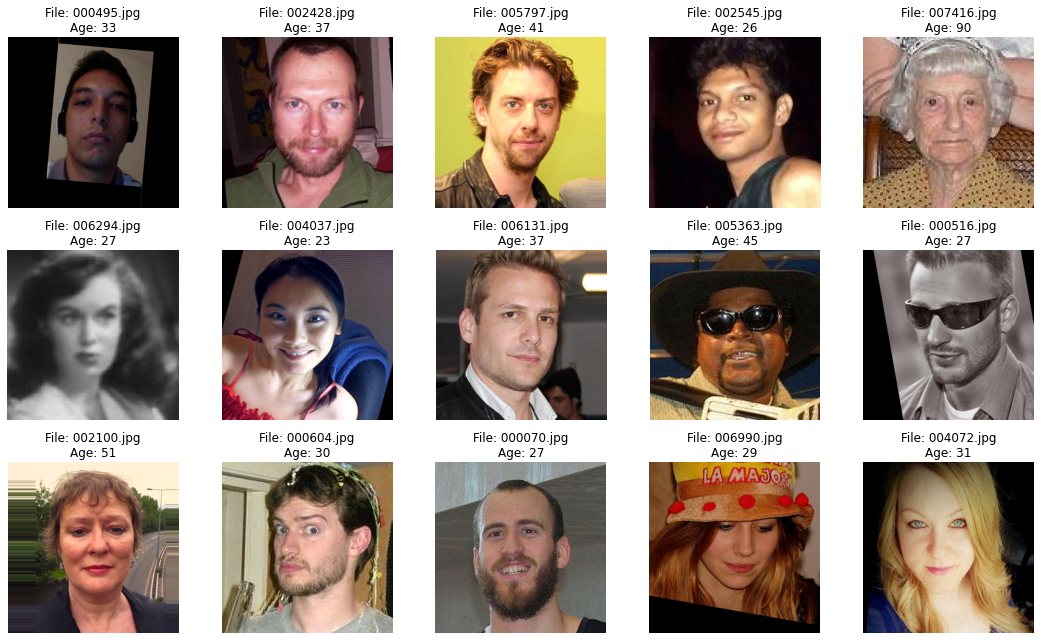

In [41]:
all_files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

files = random.sample(all_files, 15)  # можно указать кол-во семплов

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for idx, file_name in enumerate(files):
    img_path = os.path.join(path, file_name)
    img = mpimg.imread(img_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    age_info = df[df['file_name'] == file_name]['real_age'].values
    
    
    age = age_info[0]
    axes[idx].set_title(f"File: {file_name}\nAge: {age}")
    

plt.tight_layout()
plt.show()

### Вывод :

- Мы загрузили имеющиеся у нас данные.


- При анализа меток(возраста) мы определили что основную массу составляют значения в диапозоне 30-40лет.


- Так же имеются редкие выбросы и аномально низкие значения относительно медианы.


- При более детальном рассмотрении *подозрительных* данных а именно значений возраста меньше 5 и больше 90. Мы установили что фото соответсвуют заявденной *метке*


- Общий анализ показал что данные не содержат аномалий и можно переходит к построению модели.


## Обучение модели

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, Input, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, BatchNormalization, 
    Dropout, Dense, LeakyReLU
)
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

optimizer = Adam(lr=0.0005)


df = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    # horizontal_flip=True,
    # vertical_flip=True
)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255
)

def load_train(path='/datasets/faces/final_files/'):
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='file_name',      
        y_col='real_age',       
        directory='/datasets/faces/final_files/',         
        target_size=(224, 224), 
        batch_size=16,
        class_mode='raw',       
        subset='training',
        seed=42,                
        shuffle=True
    )
    
    return train_datagen_flow

def load_test(path='/datasets/faces/final_files/'):
    test_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=df,
        x_col='file_name',      
        y_col='real_age',       
        directory='/datasets/faces/final_files/',         
        target_size=(224, 224), 
        batch_size=16,
        class_mode='raw',       
        subset='validation',
        seed=42,                
        shuffle=False
    )
    
    return test_datagen_flow
def create_model(input_shape):
    '''
    Создание модели на базе ResNet50.
    input_shape: форма входного тензора.
    '''

    backbone = ResNet50(
                        input_shape=input_shape,
                        weights='imagenet',
                        include_top=False,
                       )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    # model.add(BatchNormalization())

    # model.add(Dropout(0.25))
    
    model.add(Dense(1, activation='relu'))
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None):

    # early_stopping = EarlyStopping(
    #     monitor='val_mae',
    #     patience=5,
    #     restore_best_weights=True
    # )
    
    model.fit(
        train_data, 
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, 
        shuffle=False,
        # callbacks=[early_stopping]
    )
    return model

Train for 356 steps, validate for 119 steps
Epoch 1/25
356/356 - 54s - loss: 203.5994 - mae: 10.7132 - val_loss: 563.6930 - val_mae: 18.7613
Epoch 2/25
356/356 - 44s - loss: 123.3345 - mae: 8.5137 - val_loss: 303.4793 - val_mae: 13.0389
Epoch 3/25
356/356 - 44s - loss: 85.7975 - mae: 7.1221 - val_loss: 197.1161 - val_mae: 10.8380
Epoch 4/25
356/356 - 44s - loss: 61.5698 - mae: 6.0580 - val_loss: 166.1209 - val_mae: 9.7944
Epoch 5/25
356/356 - 44s - loss: 49.1701 - mae: 5.3872 - val_loss: 170.0086 - val_mae: 9.6021
Epoch 6/25
356/356 - 44s - loss: 37.3007 - mae: 4.6937 - val_loss: 129.6489 - val_mae: 8.5514
Epoch 7/25
356/356 - 44s - loss: 28.0637 - mae: 4.0964 - val_loss: 126.0461 - val_mae: 8.4217
Epoch 8/25
356/356 - 44s - loss: 26.8307 - mae: 4.0063 - val_loss: 136.6026 - val_mae: 8.6353
Epoch 9/25
356/356 - 44s - loss: 27.1081 - mae: 4.0336 - val_loss: 123.1603 - val_mae: 8.2843
Epoch 10/25
356/356 - 44s - loss: 25.0979 - mae: 3.8978 - val_loss: 278.6286 - val_mae: 12.7428
Epoch 11/25
356/356 - 44s - loss: 22.5465 - mae: 3.6860 - val_loss: 199.2110 - val_mae: 10.3985
Epoch 12/25
356/356 - 44s - loss: 22.5528 - mae: 3.6440 - val_loss: 247.4164 - val_mae: 11.6894
Epoch 13/25
356/356 - 44s - loss: 19.2337 - mae: 3.3950 - val_loss: 166.0098 - val_mae: 9.6487
Epoch 14/25
356/356 - 43s - loss: 18.7730 - mae: 3.3284 - val_loss: 110.8109 - val_mae: 7.7485
Epoch 15/25
356/356 - 44s - loss: 16.2215 - mae: 3.1184 - val_loss: 114.9298 - val_mae: 7.9225
Epoch 16/25
356/356 - 44s - loss: 16.1847 - mae: 3.1120 - val_loss: 95.0748 - val_mae: 7.2716
Epoch 17/25
356/356 - 44s - loss: 23.9018 - mae: 3.6852 - val_loss: 118.6797 - val_mae: 7.9461
Epoch 18/25
356/356 - 44s - loss: 23.0949 - mae: 3.6708 - val_loss: 91.8024 - val_mae: 7.1225
Epoch 19/25
356/356 - 44s - loss: 17.8074 - mae: 3.2135 - val_loss: 88.4258 - val_mae: 7.0251
Epoch 20/25
356/356 - 44s - loss: 14.9338 - mae: 2.9341 - val_loss: 86.6110 - val_mae: 6.8869
Epoch 21/25
356/356 - 44s - loss: 13.0394 - mae: 2.7756 - val_loss: 141.9947 - val_mae: 8.8180
Epoch 22/25
356/356 - 40s - loss: 11.5100 - mae: 2.6166 - val_loss: 104.6338 - val_mae: 7.4915
Epoch 23/25
356/356 - 40s - loss: 10.0660 - mae: 2.4324 - val_loss: 88.8011 - val_mae: 7.0939
Epoch 24/25
356/356 - 40s - loss: 10.5996 - mae: 2.4951 - val_loss: 101.3369 - val_mae: 7.7843
Epoch 25/25
356/356 - 40s - loss: 11.1600 - mae: 2.5717 - val_loss: 98.0811 - val_mae: 7.6221
119/119 - 10s - loss: 98.0811 - mae: 7.6221

## Анализ обученной модели

В ходе перебора вариантов конфигурации модели были протестированны такие методы как :

- Добавление 3 полносвязных слоев после костяка модели ResNet50 со следующим кол-вом нейронов (512, 256 , 128) и выходным одним нейроном.(лучший результат mae был ~12)

- Так же была предпринята попытка разморозки последних 10 нейронов для доубучения модели на наших данных(метрику mae не удалось опустить ниже 16)

- Так же были попытки изменить загрузку данных в модель добавив в ImageDataGenerator параметры (horizontal_flip, vertical_flip) что увеличило время работы , но дало небольшую прибавку в точности(mae ~10)

В итоге поставленной задачи удалось добится добавив всего один выходной нейрон без изменения структуры ResNet50 с активацией 'Relu'. Видим что уже предобученая модель достаточно хорошо справляется с распознованием лиц людей.

## Вывод

Мы работали над задачей по определению возраста человека по фото в готом датасете , вот что мы проделали на этом пути :

- Загрузили датасет с метками классов , что бы посмотреть на распределение возраста. Мы обнаружили что основаная часть фото это лица людей в возрасте 30-40лет , так же имелись подозрительно малые и большие значения возраста.

- В ходе анализа подозрительных значений мы загрузили графическую часть данных и обнаружили что значения возраста >5 и 90+ соответсвуют своим меткам кдассов и данные в целом соответсвуют описанию.

- Так же удалось обнаружить что основную часть фото представленна в формате 1:1 , а разброс по качеству фотографий находился в диапозоне [47 47] - [4466 4466].

- При построении модели для анализа фото был выбран размер *стандартизации* 224-224 что позволило сохранить детализированность фото а так же приемлимое время обработки.

- Для построения предсказаний в ходе тестирования несколькиъ конфигураций модели. Мы остановились на варианте уже готовой и обученой на датасете *imagenet* модели ResNet50 добавив всего один выходной нейрон с активацией *Relu* , таким образом удалось добится метрики mae ниже 7.

## Рекомендации

По результатам работы модели ошибка в среднем составляет ~7 лет , на основании этого можно дать следующие рекомендации :

- Полностью внедрить модель для выдачи рекомендаций по покупкам , так как 7лет это незначительная разница в возрасте что бы радикально сказатся на предпочтениях клиента.

- При продаже товаров для лиц 18+ внедрить *ручную*(человеческую) проверку документов при определении моделью возраста <30.